In [2]:
import math
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import scipy.stats
import numpy as np
import scipy.linalg as spla
import os
import numbers
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy
from scipy.linalg import sqrtm
from arch import arch_model
%matplotlib inline
from pathlib import Path
from os import listdir
from os.path import isfile, join
from datetime import datetime

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
#plt.style.use("bmh") #"seaborn-deep" "seaborn-paper"
from functools import reduce
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [86]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

# Input Data

In [ ]:
df1 = pd.read_csv('/Users/ayanaaspembitova/work/Euler/SwapData/price/ETH-USDT15min.csv', usecols = ['date', 'price'])
df1.columns = ['date', 'eth']
df2 = pd.read_csv('/Users/ayanaaspembitova/work/Euler/SwapData/price/AAVE-ETH15min.csv',  usecols = ['date', 'price'])
df2.columns = ['date', 'aave']
df = df1.merge(df2, on=['date'])

In [ ]:
df = df.set_index('date')
df = df.fillna(method='bfill')
df = df.dropna()
returns = 100*df.pct_change().dropna()
log_returns = 100*(np.log(df) - np.log(df.shift(1))).dropna()

In [ ]:
df_trade = pd.read_csv('/Users/ayanaaspembitova/work/Euler/SwapData/AAVE-ETH15min.csv', usecols = ['timestamp', 'amount0', 'amount1', 'amount0_usd'])
df_trade = df_trade.fillna(0)


# Price simulator

In [ ]:
def multivaraiate_normal_sampler(mean, covariance, n_samples=1):
    
    L = spla.cholesky(covariance)
    Z = np.random.normal(size=(n_samples, covariance.shape[0]))
    
    return Z.dot(L) + mean

In [ ]:
def multivariate_student_t_sampler(mean, cov, dof, n_samples=1):
    #multivariate student-t distribution has covariance matrix equals to (dof/(dof-2) * Sigma) and the same mean
    m = mean.shape[0]
    u = np.random.gamma(dof / 2., 2. / dof, size = (n_samples,1))
    Y = multivaraiate_normal_sampler(np.zeros((m, )), cov, n_samples)
    
    return Y / np.tile(np.sqrt(u), [1,m]) + mean

## Brownian motion 

In [ ]:
def simulate_Brownian_mult(So, mu, sigma, mQ, returns, n):
    #maxs = returns.max().values*1.3 # restriction on max/min values of returns
    #mins = returns.min().values*1.3
    white_noise = multivaraiate_normal_sampler(mu, mQ, n)
    d = returns.shape[1]
    ret = np.zeros((n, d))
    S = np.zeros([n, d])
    

    for t in range(1, n):
        ret[t] = mu + np.sqrt(sigma2)*white_noise[t][0]
        #ret[t] = ret[t].clip(max=maxs, min=mins)
    
        S[t, :] = S[t-1, :] * (1 + ret[t,:] / 100)
        St = S[t, :]
        St[np.where(St <0)] = 0 #to avoid negative prices
        S[t, :] = St
    return ret, S

## GARCH (univariate and multivariate) 

In [ ]:
def fit_GARCH(ret, dist):

    scaling_const = 1.0 #/ ret.std()

    am = arch_model(ret * scaling_const,
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')
    alpha = pd.DataFrame(res.params).filter(regex='alpha', axis=0).values[0][0]
    beta = pd.DataFrame(res.params).filter(regex='beta', axis=0).values[0][0]

    # try parts of t-s to get stationary model
    cut_p = np.arange(0.05,0.6,0.05)
    i = 0
    while ((alpha + beta) > 0.9999) & (i < len(cut_p)):
        y = np.int(len(ret) * cut_p[i])
        ret_cut = ret[y:]
        am = arch_model(ret_cut * scaling_const,
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged
        i = i + 1
        res = am.fit(update_freq=0, disp='off')
        alpha = pd.DataFrame(res.params).filter(regex='alpha', axis=0).values[0][0]
        beta = pd.DataFrame(res.params).filter(regex='beta', axis=0).values[0][0]
    
    return am, res, scaling_const

In [ ]:
def fit_mult_GARCH(returns, dist):
    
    eps = pd.DataFrame(columns=returns.columns)
    distribution_params = {}
    df_params = pd.DataFrame(columns=returns.columns)

    # Fit marginal distributions for each asset
    ret_dim = returns.shape[0]
    for col in returns.columns:
        print(col)
        am, res, scaling_const = fit_GARCH(returns[col], dist)
        cond_vol = res.conditional_volatility.to_numpy().reshape(len(res.resid),1)
        a = np.empty(len(returns[col]) - len(res.resid))
        a[:] = np.nan

        eps[col] = returns[col].values / np.concatenate([a, cond_vol.T[0]])
        
        alpha = pd.DataFrame(res.params).filter(regex='alpha', axis=0).values[0][0]
        beta = pd.DataFrame(res.params).filter(regex='beta', axis=0).values[0][0]
        nu = pd.DataFrame(res.params).filter(regex='nu', axis=0).values[0][0]
        omega = pd.DataFrame(res.params).filter(regex='omega', axis=0).values[0][0]
        a0 = res.params[0]
        a1 = res.params[1]
        df_params[col] = [alpha, beta, omega, a0, a1, scaling_const] 
        
        print(alpha + beta, nu)
        distribution_params[col] = (am, res, scaling_const)
        
    return distribution_params, df_params, eps

In [ ]:
def simulate_Student_t_GARCH_mult(So, dof, n, mQ, returns, df_params):

    d = returns.shape[1]
    
    maxs = returns.max().values*1.3 # restriction on max/min values of returns
    mins = returns.min().values*1.3 # restriction on max/min values of returns

    ret = np.zeros((n, d))
    stdres = np.zeros((n, d))
    sigma2 = np.zeros((n, d))
    
    [alpha, beta, omega, a0, a1, scaling_const] = df_params.values
    
    mu = np.zeros((1, d)) # initial mu
    sigma2[0] = omega / (1 - alpha - beta) # initial sigma
    
    white_noise = np.sqrt((dof - 2) / dof) * multivariate_student_t_sampler(np.zeros((d, )), mQ, dof, n) 

    ret[0] = returns[-1:].values
    S = np.zeros([n, d])
    S[0, :] = So
    #loop over sims
    for t in range(1, n):
        
        mu = a0 + a1 * ret[t-1]
        sigma2[t] = omega + alpha * (ret[t-1] - mu)**2 + beta * sigma2[t-1]
        ret[t] = mu + np.sqrt(sigma2[t]) * white_noise[t]
        ret[t] = ret[t].clip(max=maxs, min=mins)
        stdres[t] = ret[t] / np.sqrt(sigma2[t])
            
        S[t, :] = S[t-1, :] * (1 + ret[t,:] / 100)
        St = S[t, :]
        St[np.where(St <0)] = 0 #to avoid negative prices
        S[t, :] = St
    
    return ret, S               

In [ ]:
distribution_params, df_params, eps = fit_mult_GARCH(returns, 't')

mQ = eps.dropna().cov() # unconditional covariance matrix of standartized residuals
n = 5000
dof = 4

start=datetime.now()
So = df.iloc[-1,:]
ret, S = simulate_Student_t_GARCH_mult(So, dof, n, mQ, returns, df_params)

In [ ]:
ret_sim = pd.DataFrame(ret)
ret_sim.columns = returns.columns

N = ret_sim.shape[0]
S = np.zeros([2, int(N)])
S[:, 0] = df.iloc[-1,:]

for i in range(1, int(N)): 
    
    S[:, i] = S[:, i-1] * (1 + ret_sim.iloc[i,:].values / 100)
    
sim_prices_df = pd.DataFrame(S.T, columns = returns.columns)

# Trade Simulator

In [ ]:
#Random sampling from a given distribution: 

def simulate_log_random_trades(mean_pos, mean_neg, s_pos, s_neg, size_pos, size_neg, low_pos, low_neg, high_pos, high_neg): 
    neg_dist = scipy.stats.lognorm(mean_neg, s_neg)
    pos_dist = scipy.stats.lognorm(mean_pos, s_pos)
    points = np.array([])
    points_pos = np.array([])
    points_neg = np.array([])
    N = size_neg+size_pos

    while points_pos.size < size_pos:
        x = pos_dist.rvs(size_pos)
        ix = x < high_pos
        ix = ix & (low_pos < x)
        points_pos = np.hstack([points_pos, x[ix]])
    while points_neg.size < size_neg:
        x = neg_dist.rvs(size_neg)
        ix = x < high_neg
        ix = ix & (low_neg < x)
        points_neg = np.hstack([points_neg, x[ix]])
        points_neg = [ -x for x in points_neg]
        #points = np.concatenate([points_pos, points_neg])
        points = np.random.choice(np.concatenate([points_pos, points_neg]), N)
        return points
    

In [ ]:
#According to Uni V2 formula, get size of the trade to match external price

def trades_from_price(price_x, price_y, x, y):
    p_x = price_x/price_y
    dx = math.sqrt(p_x*y*x)-x
    dy = -(y*(dx/(x+dx)))
    x1 = x+dx
    y1 = y+dy
    return dx, dy, x1, y1

# Arbitrage Module

In [ ]:
#CPAMM formula, get size of the trade to match external price

def trades_from_price_cp(pj, x, y):
    dx = math.sqrt(pj*y*x)-x
    dy = y*(dx/(x+dx))
    return dx, dy

In [ ]:
#Curve V1
def calculate_derivative (x, A, D, s):
    #d = -(0.5/np.sqrt((D**3/(A*x) + ((1-1/A)*D - x)**2))) * (-D**3/(A*x**2) - 2*((1-1/A)*D - x)) - s
    d=-0.5*(-1+0.5/np.sqrt((D**3/(A*x)+((1-1/A)*D-x)**2)) * (-D**3/(A*x**2)-2*((1-1/A)*D-x))) - s
    return d

def get_trades_from_price_c1(x_initial_guess, A, D, x, y, pj)
    liquidity = x + y
    x1 = fsolve(calculate_derivative, x_initial_guess, args = (A, liquidity, pj) )
    dx = x-x1[0]
    
    b = (1 - 1 / A) * D - x1[0]
    dsc = 4*D * (D/2)**2 / (A*x1[0]) + b**2
    y1 = (np.sqrt(dsc) + b) / 2
    dy = y-y1
    return dx, dy

In [ ]:
#EulerSwap(new):



# Uniswap V2 implementation

In [ ]:
def univ2(dx, price_x, price_y, liquidity):
    x = (liquidity/2)/price_x
    y = (liquidity/2)/price_y
    dy = y*(dx/(x+dx)) 
    
    x1 = x + dx
    y1 = y + dy
    price = dx/dy
    slippage = abs((x/y - x1/y1) / (x/y))
    balance = 1 - abs(price_x*x1/(price_x*x1+price_y*y1) - 1/2) - abs(price_y*y1/(price_x*x1+price_y*y1) - 1/2)
    return dy, price, slippage, balance

# Curve implementation

In [ ]:
def curve(dx, D, A):
    x = (liquidity/2)
    y = (liquidity/2)
    
    x1 = x + dx

    b = (1 - 1 / A) * D - x1
    dsc = D**3 / (A*x1) + b**2
    y1 = (np.sqrt(dsc) + b) / 2
    dy = y - y1

    balance = 1 - abs(x1/(x1+y1) - 1/2) - abs(y1/(x1+y1) - 1/2)
    spot = x*(A*x*y + D**3/4)/(y*(A*x**2 + D**3/4))
    spot1 = x1*(A*x1*y1 + D**3/4)/(y1*(A*x1**2 + D**3/4))
    slippage = abs(spot1/spot - 1) #abs(abs(dx/dy) / spot - 1)
    #x1_solution = fsolve(cost_of_slippage, x, args = (x, y, s, A, D))
    #cost_of_slip = abs(x1_solution[0] - x)

    return dy, slippage, balance

# EulerSwap implementation (no fees)

In [ ]:
#CSAMM, CPAMM, ES
def CSAMM(x):
    return 2-x

def CPAMM(x):
    return 1/x

def ES(x, c): #Solving for y
    return (-c / (2 - c)) * x + (2 / (2 - c)) * math.pow(x, -(1 - c)) #x ** (-(1-c))# math.pow(x, -(1 - c))

def dfdx(x, y, c): #y'
    return -c - ((1 - c) * y) / x

def dfdx2(x, c):
    return (-2 * math.pow(x, 2) + c * math.pow(x, 2)) / ((1 - c) * 2 * math.pow(x, c) + c * math.pow(x, 2))

def finv(x, c): #Newton's method 
    n = 0
    xn = (2 * x ** (c - 1)) / 2 - c  #c * CSAMM(x) + (1 - c) * CPAMM(x)
    while n < 15:
        xn = xn - (ES(xn, c) - x) / dfdx(xn, x, c)
        n += 1
    return xn

In [ ]:
def ES_x_swap(amount, c, reserve_x, reserve_y, py, x, y):
    virtual_x = reserve_y * py
    virtual_y = reserve_x * (1/py) 
    
    if x >= 1:
        x_in = amount / virtual_x 
        y_out = y - finv(x + x_in, c) 
        y_out_real = y_out * reserve_y 
    else:
        if x + amount / reserve_x < 1:

            x_in = amount / reserve_x 
            y_out = y - ES(x + x_in, c) 
            y_out_real = y_out * virtual_y # + amount in + fees
        else:
            x_in_f_part = 1 - x
            x_in_f_part_real = x_in_f_part * reserve_x
            x_in_g_part_real = amount - x_in_f_part_real
            x_in_g_part = x_in_g_part_real / virtual_x
            x_in = x_in_f_part + x_in_g_part
            y_out_f_part = y - 1
            y_out_g_part = 1 - finv(1 + x_in_g_part, c)
            y_out = y_out_f_part + y_out_g_part
            y_out_f_part_real = y_out_f_part * virtual_y  # + amount in + fees
            y_out_g_part_real = y_out_g_part * reserve_y
            y_out = y_out_g_part_real + y_out_f_part_real
            y_out_real = y_out_f_part_real + y_out_g_part_real
            
    x = x + x_in 
    y = y - y_out
    reserve_x = reserve_x + amount
    reserve_y = reserve_y - y_out_real
    p_eff = amount/(y_out_real+0.0001)
            
    return amount, y_out_real, reserve_x, reserve_y, p_eff, x, y

In [ ]:
def ES_y_swap(amount, c, reserve_x, reserve_y, py, x, y):
    virtual_x = reserve_y * py
    virtual_y = reserve_x * (1/py)
    
    if y >= 1:
            # we're in g here
        y_in = amount / (virtual_y+0.00001) # normalise the amount in
        x_out = x - finv(y + y_in, c) # calculate the new x position
        x_out_real = x_out * reserve_x # calculate the real x out
    else:
        if y + amount / reserve_y < 1:
                # we're in g here
            y_in = amount / reserve_y
            x_out = x - ES(y + y_in, c) # calculate the new x position
            x_out_real = x_out * virtual_x # calculate the real x out
        else:
                # we're in g and then f here
            y_in_g_part = 1 - y
            y_in_g_part_real = y_in_g_part * reserve_y
            y_in_f_part_real = amount - y_in_g_part_real
            y_in_f_part = y_in_f_part_real / virtual_y
            y_in = y_in_g_part + y_in_f_part
            x_out_g_part = x - 1
            x_out_f_part = 1 - finv(1 + y_in_f_part, c)
            x_out = x_out_g_part + x_out_f_part
            x_out_g_part_real = x_out_g_part * virtual_x
            x_out_f_part_real = x_out_f_part * reserve_x
            x_out_real = x_out_g_part_real + x_out_f_part_real
            
    y = y + y_in 
    x = x - x_out 
    reserve_y = reserve_y + amount
    reserve_x = reserve_x - x_out_real
    p_eff = x_out_real/(amount+0.00001)
            
    return x_out_real, amount, reserve_x, reserve_y, p_eff, x, y #, slippage

# ES Implementation + fee attribution

In [ ]:
#Functions to calculate output amounts (Old stuff):
'''
def getYEulerSwapExcess(amount, x_price, y_price):
    y_in = (x_price / y_price) * (amount)
    return y_in

def getXEulerSwapExcess(amount, x_price, y_price):
    y_in = (x_price / y_price) * (amount)
    return y_in

def getYEulerSwap(x_coord, x, c_x): 
    y_new = (2 * math.pow(x_coord/x, c_x - 1) - (c_x * x_coord) / x) /(2 - c_x)
    return y_new

def getXEulerSwap(x_out, y_virtual, x_price, y_price, x_reserve, y_reserve, y_coord, x_coord): 
    n = 0 
    n_max = 100 
    csamm = (x_price / y_price) * x_out
    cpamm = y_virtual*(x_out/(x_reserve+x_out))
    start_x = csamm
    end_x = cpamm
    y_estimate_n = (start_x + end_x) / 2
    y_coord_estimate_n = y_coord - y_estimate_n
    y_coord_estimate_norm = y_coord_estimate_n/y_reserve
    x_coord_estimate_n = getYEulerSwap(y_coord, y_reserve, x_virtual, 1) * x_virtual
    
    while n < n_max:
        if x_coord_estimate_n > x_coord:
            start_x = y_estimate_n
        else:
            end_x = y_estimate_n
        y_estimate_n = (start_x + end_x) / 2
        y_coord_estimate_n = y_coord - y_estimate_n
        y_coord_estimate_norm = y_coord_estimate_n/y_reserve
        x_coord_estimate_n = y_coord - getYEulerSwap(x_coord, x_reserve, y_virtual, 1)
        n += 1
        x_out_estimate = x_coord - x_coord_estimate_n
        y_in_estimate = y_coord - y_coord_estimate_n
    return y_in_estimate '''

In [155]:
#Functions to calculate output amounts :

def getYEulerSwapExcess(amount, x_price, y_price):
    y_in = (x_price / y_price) * (amount)
    return y_in

def getXEulerSwapExcess(amount, x_price, y_price):
    y_in = (x_price / y_price) * (amount)
    return y_in

def getYEulerSwap(c, x0, x, dx, px, py):
    y_new = px/py*(c*(2*x0 - (x+dx)) + (1-c)* ((x **2)/x+dx))
    return y_new

def getXEulerSwap(c, y0, x, dx, px, py):
    y_new = - ((x+dx) * px/py - 2*c*y0 - np.sqrt(((x+dx) * px/py - 2*c*y0)**2 + 4*c*(1-c)*y0**2))/2*c
    return y_new

In [49]:
#Swap functions with fee attribution logic:

def swapXOutXSide(x_out_X_side, x_excess, y_excess, fee, c_x, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord, x_centre): 
    y_in_X_side = 0
    x_coord = x_coord - x_out_X_side
    x_coord_norm = x_coord/x_reserve
    y_coord_norm = y_coord/y_reserve
    x_virtual = (y_reserve * y_price)/x_price
    y_virtual = (x_reserve * x_price)/y_price
    
    if x_coord_norm >= x_centre: # X excess curve
        y_in_X_side = getYEulerSwapExcess(x_out_X_side, x_price, y_price)
        active_region = 2
    else: # X main curve
        #y_in_X_side = (getYEulerSwap(x_coord_norm, 1, c_x) - y_coord_norm) * y_virtual
        y_in_X_side = y_coord - getYEulerSwap(c_x, x_reserve, x_out_X_side, x_price, y_price)
        active_region = 1
        x_reserve -= x_out_X_side
        
    y_in_X_side_fee = fee * y_in_X_side
    y_excess += y_in_X_side_fee
    x_excess += 0
    #y_in += y_in_X_side_fee 
    
    y_reserve +=y_in_X_side
    y_coord += y_in_X_side_fee
    
    return x_out_X_side, y_in_X_side, y_in_X_side_fee, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord

In [59]:
def swapXOutYSide(x_out_Y_side, c, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord, x_centre):
    x_coord_norm = x_coord/x_reserve
    y_coord_norm = y_coord/y_reserve
    x_virtual = (y_reserve * y_price)/x_price
    y_virtual = (x_reserve * x_price)/y_price
    
    y_in_Y_side = 0
    x_out_Y_side_max = x_coord - x_virtual 
        #the difference between x-coordinate of the external boundary of the Y excess curve and the current x-coordinate
    if x_out_Y_side <= x_out_Y_side_max: #x-coordinate on the Y side
        x_out_Y_side_fee = fee * x_out_Y_side
        x_coord -= x_out_Y_side - x_out_Y_side_fee 
        if x_coord >= x_virtual + x_excess: #Y main curve
            #y_in_Y_side = getXEulerSwap(x_out_Y_side, y_virtual, x_price, y_price, x_reserve, y_reserve, y_coord, x_coord) 
            y_in_Y_side = y_coord - getXEulerSwap(c, x_coord, x_out_Y_side, x_price, y_price)
            x_coord -= x_out_Y_side
            active_region = 1
        else: #Y excess curve
            y_in_Y_side = getXEulerSwapExcess(x_out_Y_side, x_price, y_price)
            active_region = 2
                
        y_coord += y_in_Y_side
        x_excess += x_out_Y_side_fee 
        y_excess += 0
            
        return x_out_Y_side, y_in_Y_side, x_out_Y_side_fee, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord
            
    else: #x-coordinate somewhere on the X side
        active_region = 0
        x_out_X_side = x_out_Y_side - x_out_Y_side_max 
        x_out_Y_side = x_out_Y_side_max
        x_out_Y_side_fee = fee * x_out_Y_side
        x_coord -= x_out_Y_side - x_out_Y_side_fee
        y_in_Y_side = getXEulerSwapExcess(x_out_Y_side, x_price, y_price)
        #active_region = 2
            
        x_excess += x_out_Y_side_fee
        y_excess += 0
        #x_coord = x_reserve + (y_excess * y_price) / x_price 
        #y_coord = y_virtual
       # y_in_X_side, y_in_X_side_fee
        x_out, y_in_X_side, y_in_X_side_fee, active_region0, x_reserve0, y_reserve0, x_excess0, y_excess0, x_coord0, y_coord0 = swapXOutXSide(x_out_X_side, x_excess, y_excess, fee, c, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord, x_centre)
        #active_region = 1
        x_reserve -= x_out_X_side
        y_reserve += (y_in_Y_side+ y_in_X_side)
        
        x_excess += x_out_Y_side_fee
        y_excess += y_in_X_side_fee
        y_coord += (y_in_X_side+y_in_Y_side+y_excess) 
        x_coord = x_coord - (x_out_Y_side+ x_out_X_side) + x_excess #Is this right?

        return x_out_X_side + x_out_Y_side, y_in_Y_side+ y_in_X_side, x_out_Y_side_fee + y_in_X_side_fee, active_region, x_excess, y_excess, x_coord, y_coord

In [88]:
def swapXInYSide(x_in_Y_side, c, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord): 
    y_out_Y_side = 0
    x_in_Y_side_fee = fee * x_in_Y_side
    x_in_Y_side -= x_in_Y_side_fee
    x_coord += x_in_Y_side
    
    x_coord_norm = x_coord/x_reserve
    y_coord_norm = y_coord+y_excess/y_reserve
    x_virtual = (y_reserve * y_price)/x_price
    y_virtual = (x_reserve * x_price)/y_price
    
    if x_coord_norm <= 1: #x_virtual + x_excess: #x-coordinate on Y excess curve
        y_out_Y_side = getXEulerSwapExcess(x_in_Y_side, x_price, y_price) - y_coord
        active_region = 2
    else: # x-coordinate on Y main curve
        y_out_Y_side = getXEulerSwap(c, x_coord, x_in_Y_side, x_price, y_price) 
        active_region = 1
        #y_reserve -=y_out_Y_side
        
    y_coord -= y_out_Y_side 
    x_excess += x_in_Y_side_fee 
    y_excess +=0
    #x_coord +=x_in_Y_side_fee

    #x_reserve+=x_in
    
    return x_in_Y_side, y_out_Y_side, x_in_Y_side_fee, active_region, x_excess, y_excess, x_coord, y_coord

In [90]:
swapXInYSide(10, 1, 20, 0, 0.02, 2000, 1000, 1, 2, 2000, 1000)

(9.8, 990.2, 0.2, 1, 20.2, 0, 2009.8, 9.799999999999955)

In [ ]:
def swapXInXSide(x_in_X_side, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord):
    x_coord_norm = x_coord/x_reserve
    y_coord_norm = y_coord/y_reserve
    x_virtual = (y_reserve * y_price)/x_price
    y_virtual = (x_reserve * x_price)/y_price
    
    y_out_X_side = 0 
    x_in_X_side_max = (x_reserve + (y_excess * y_price) / x_price) - x_coord  #(x_coord_norm - x_centre) * x_reserve + (y_excess * y_price) / x_price  #x_coord - x_reserve + (y_excess * y_price) / x_price 
    #the difference between x-coordinate of the external boundary of the X excess curve and the current x-coordinate
    if x_in_X_side <= x_in_X_side_max: #x-coordinate somewhere on the X side
        x_coord += x_in_X_side
        x_coord_norm = x_coord/x_reserve
        
        if x_coord <= x_reserve: #x-coordinate on X main curve
            y_out_X_side = y_coord - getYEulerSwap(x_coord, x_reserve, y_virtual, c_x)
            active_region = 1
            #y_out_X_side_fee = fee * y_out_X_side
            #y_out_X_side -= y_out_X_side_fee
            #y_reserve -= y_out_X_side
        else: #x-coordinate on X excess curve
            y_out_X_side = getYEulerSwapExcess(x_in_X_side, x_price, y_price)
            active_region = 2
        
        y_coord -=y_out_X_side
        y_out_X_side_fee = fee * y_out_X_side
        y_out_X_side -= y_out_X_side_fee
        y_excess += y_out_X_side_fee
        x_excess += 0
        y_coord += y_out_X_side_fee
        #x_reserve += x_in_X_side
        

        
        return x_in_X_side, y_out_X_side, y_out_X_side_fee, active_region, x_excess, y_excess, x_coord, y_coord
        
    else: #x-coordinate somewhere on the Y side
        active_region = 0
        x_in_Y_side = x_in_X_side - x_in_X_side_max
        x_in_X_side = x_in_X_side_max
        y_out_X_side = y_coord - y_reserve
        
        y_out_X_side_fee = fee * y_out_X_side
        y_out_X_side -= y_out_X_side_fee
        #x_coord = x_virtual
        #y_coord = y_reserve + (x_excess * x_price) / y_price
        
        x_in, y_out_Y_side, x_in_Y_side_fee, active_region0, x_excess0, y_excess0, x_coord0, y_coord0 = swapXInYSide(x_in_Y_side, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
        x_reserve += (x_in_X_side + x_in_Y_side)
        y_reserve -= (y_out_Y_side+ y_out_X_side)
        y_excess += y_out_X_side_fee 
        x_excess += 0#x_in_Y_side_fee 
        
        y_coord =  y_coord -(y_out_X_side+y_out_Y_side)
        x_coord += (x_in_Y_side+ x_in_X_side)
        
        return x_in_Y_side+ x_in_X_side, y_out_X_side+y_out_Y_side, y_out_X_side_fee + x_in_Y_side_fee, active_region, x_excess, y_excess, x_coord, y_coord

# Swap logic without fees and excess curves

In [4]:
def getYEulerSwap(c, x0, x, dx, px, py):
    y_new = px/py*(c*(2*x0 - (x+dx)) + (1-c)* ((x ** 2)/x+dx))
    return y_new

In [5]:
def getXEulerSwap(c, y0, x, dx, px, py):
    y_new = - ((x+dx) * px/py - 2*c*y0 - np.sqrt(((x+dx) * px/py - 2*c*y0)**2 + 4*c*(1-c)*y0**2))/2*c
    return y_new

In [429]:
#Swap functions with fee attribution logic:

def swapXOutXSide(x_out_X_side, c_x, x_centre, x_coord, y_coord, x_price, y_price): 

    y_in_X_side = getYEulerSwap(c_x, x_centre, x_coord, x_out_X_side, x_price, y_price) - y_coord
    x_coord -= x_out_X_side
    y_coord = y_coord + y_in_X_side
    
    return x_out_X_side, y_in_X_side, x_coord, y_coord

In [430]:
def swapXInXSide(x_in_X_side, c_x, y_centre, x_coord, y_coord, x_price, y_price):  
    y_out_X_side = getYEulerSwap(c_x, y_centre, x_coord, x_in_X_side, x_price, y_price) - y_coord
            
    y_coord -= y_out_X_side
    x_coord += x_in_X_side
        
    return x_in_X_side, y_out_X_side, x_coord, y_coord

In [813]:
#Swap functions with fee attribution logic:

def swapXOutXSide(x_out_X_side, c, x_centre, y_centre, x_coord, y_coord, x_price, y_price): 

    y_in_X_side = getYEulerSwap(c, x_centre, x_coord, x_out_X_side, x_price, y_price) - y_coord
    x_coord = x_coord + x_out_X_side
    y_coord = y_coord + y_in_X_side
    
    return x_out_X_side, y_in_X_side, x_coord, y_coord

In [943]:
def swapXOutYSide(x_out_Y_side, c, x_centre, y_centre, x_coord, y_coord, x_price, y_price):
    y_in_Y_side = 0
    
    x_out_Y_side_max = x_coord - x_centre 
        
    if abs(x_out_Y_side) <= x_out_Y_side_max: #x-coordinate on the Y side
        
        y_in_Y_side = getXEulerSwap(c, x_centre, x_coord, x_out_Y_side, x_price, y_price) - y_coord
        x_coord += x_out_Y_side       
        y_coord += y_in_Y_side
        
        return x_out_Y_side, y_in_Y_side, x_coord, y_coord
            
    else: #x-coordinate somewhere on the X side
        x_out_X_side = abs(x_out_Y_side) - x_out_Y_side_max 
        x_out_Y_side = x_out_Y_side_max
        y_in_Y_side = x_out_Y_side/y_price
        
        x_coord -=abs(x_out_Y_side)
        y_coord += y_in_Y_side
        
        y_in_X_side = getYEulerSwap(c, x_centre, x_coord, x_out_X_side, x_price, y_price) - y_coord
  
        y_coord += y_in_X_side 
        x_coord = x_coord - abs(x_out_X_side)

        return x_out_X_side + x_out_Y_side, y_in_Y_side+ y_in_X_side, x_coord, y_coord

In [731]:
def swapXInYSide(x_in_Y_side, c, x_centre, y_centre, x_coord, y_coord, x_price, y_price): 
    y_out_Y_side = 0
    x_coord += x_in_Y_side

    y_out_Y_side = getXEulerSwap(c, x_centre, x_coord, x_in_Y_side, x_price, y_price) 
        
    y_coord -= y_out_Y_side 
    
    return x_in_Y_side, y_out_Y_side, x_coord, y_coord

In [732]:
def swapXInXSide(x_in_X_side, c, x_centre, y_centre, x_coord, y_coord, x_price, y_price):
    
    y_out_X_side = 0 
    x_in_X_side_max = x_centre - x_coord 
    
    if x_in_X_side <= x_in_X_side_max: #x-coordinate somewhere on the X side
        x_coord += x_in_X_side
        
        y_out_X_side = y_coord - getYEulerSwap(x_coord, x_reserve, y_virtual, c_x)
            
        y_coord -=y_out_X_side

        return x_in_X_side, y_out_X_side, x_coord, y_coord
        
    else: #x-coordinate somewhere on the Y side
        x_in_Y_side = x_in_X_side - x_in_X_side_max
        x_in_X_side = x_in_X_side_max
        y_out_X_side = y_coord - y_centre
        
        x_in, y_out_Y_side, x_coord0, y_coord0 = swapXInYSide(x_in_Y_side, c, x_centre, y_centre, x_coord, y_coord, x_price, y_price)
 
        y_coord =  y_coord -(y_out_X_side+y_out_Y_side)
        x_coord += (x_in_Y_side+ x_in_X_side)
        
        return x_in_Y_side+ x_in_X_side, y_out_X_side+y_out_Y_side, x_coord, y_coord

In [73]:
price_x = 1
price_y0 = 2
x0 = 10000
y0 = x0/price_y0
dx = 10
c=0.7
yt = price_x/price_y0 * (c *(2*x0 - (x0-dx)) + (1-c)* (x0**2/x0-dx))
yt - y0

2.0

In [114]:
#IL calculations as function of c: 
price_x = 1
price_y = 2
x0 = 100000000
y0 = x0/price_y0
dx = 10
cs = np.arange(0, 1.1, 0.1)
df = pd.DataFrame()
df1 = pd.DataFrame()
ils = []
for c in cs:
    yt = price_x/price_y * (c *(2*x0 - (x0-dx)) + (1-c)* (x0**2/x0-dx))
    dy = yt - y0
    xt = x0 - dx + dy * price_y/price_x
    il = (x0 - xt)/x0
    ils.append(il)

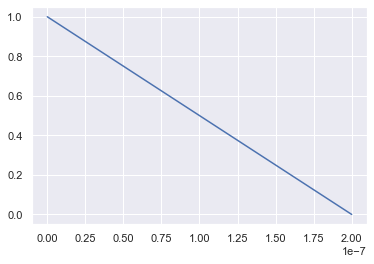

In [115]:
plt.plot(ils, cs)

In [91]:
#IL calculations as function of c: 
price_x = 1
price_y0 = 2
x0 = 100000000
y0 = x0/price_y0
dx = 10
cs = np.arange(0, 1, 0.1)
returns = np.arange(0, 0.5, 0.01)
df = pd.DataFrame()
df1 = pd.DataFrame()
for c in cs:
    ils = []
    dys = []
    for ret in returns: 
        price_y = price_y0 - price_y0*ret
        yt = price_x/price_y * (c *(2*x0 - (x0+dx)) + (1-c)* (x0**2/x0+dx))
        dy = yt - y0
        xt = x0 - dx + dy * price_y/price_x
        il = (x0 - xt)/x0
        dys.append(dy)
        ils.append(il)
    df[c] = ils
    #df1['dy_c{}'.format(c)] = dys

In [92]:
df.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,2.000000e-08,4.000000e-08,6.000000e-08,8.000000e-08,1.000000e-07,1.200000e-07,1.400000e-07,1.600000e-07,1.800000e-07
1,-0.01,-9.999980e-03,-9.999960e-03,-9.999940e-03,-9.999920e-03,-9.999900e-03,-9.999880e-03,-9.999860e-03,-9.999840e-03,-9.999820e-03
2,-0.02,-1.999998e-02,-1.999996e-02,-1.999994e-02,-1.999992e-02,-1.999990e-02,-1.999988e-02,-1.999986e-02,-1.999984e-02,-1.999982e-02
3,-0.03,-2.999998e-02,-2.999996e-02,-2.999994e-02,-2.999992e-02,-2.999990e-02,-2.999988e-02,-2.999986e-02,-2.999984e-02,-2.999982e-02
4,-0.04,-3.999998e-02,-3.999996e-02,-3.999994e-02,-3.999992e-02,-3.999990e-02,-3.999988e-02,-3.999986e-02,-3.999984e-02,-3.999982e-02


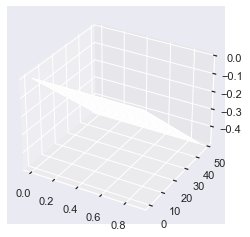

In [95]:
x = df.columns
y = df.index
X,Y = np.meshgrid(x,y)
Z = df
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

In [ ]:
ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.2)
plt.show()

In [379]:
amounts_x = test_set['amount0']
amounts_y = test_set['amount1']
y_prices = test_set['ma']
y_price = test_set['ma'].iloc[0]
x_price = 1
y_ps = []
x0 = 100000000
y_total = 0
x_total = x0
x_totals = []
y_totals = []
x_centre = x0
y_centre = x_centre/y_price
c = 1
y_coord = x_centre/y_price
x_coord = x0
x_coords = []
dys = []
dxs = []

for amount_x, amount_y, y_price in zip(amounts_x, amounts_y, y_prices):
    #y_coord = x_centre/y_price
    #x_coord = x_centre
    if amount_x < 0:
        if x_coord <=x_centre: # f(x)
            y_in = getYEulerSwap(c, x_centre, x_coord, amount_x, x_price, y_price) - y_coord
            y_total += abs(y_in)
            x_total -=abs(amount_x)
            x_coord = x_coord - abs(amount_x)
            y_coord = y_coord + abs(y_in)
            dys.append(abs(y_in))
            dxs.append(amount_x)
        else: 
            y_in = x_coord - getXEulerSwap(c, x_centre, y_coord, abs(amount_y), y_price, x_price)
            x_coord = x_coord - abs(amount_x)
            y_coord = y_coord + abs(y_in)
            dys.append(abs(y_in))
            dxs.append(amount_x)
    else:
        if abs(amount_y) < y_total:
            y_total -= abs(amount_y)
            amount_x = x_coord - getXEulerSwap(c, x_centre, y_coord, abs(amount_y), y_price, x_price)
            x_total+=amount_x
            #x_coord += amount_x
            #y_coord -=abs(amount_y)
            dys.append(amount_y)
            dxs.append(amount_x)
        else: 
            y_total = 0
            x_total += (abs(amount_y) - y_total) * 1/y_price
            #y_coord -=abs(amount_y)
            dys.append(amount_y)
            dxs.append(amount_x)
    x_totals.append(x_total) 
    y_totals.append(y_total)
    y_ps.append(y_price)

In [380]:
il_x1 = pd.DataFrame()
il_x1['x_coords'] = x_totals
il_x1['price'] = y_ps
il_x1['y_total'] = y_totals
il_x1['dy'] = dys
il_x1['dx'] = dxs
il_x1['p_eff'] = il_x1['dx']/il_x1['dy']
#il_x1['regions'] = regions
il_x1['value_x'] = il_x1['x_coords'] + il_x1['y_total']*il_x1['price']
#il_x = il_x.iloc[1:]
il_x1['il'] = (il_x1['value_x'] - x0)/x0
il_x1['return'] = (il_x1['price'].shift(1) - il_x1['price'].iloc[0]) / il_x1['price'].iloc[0]

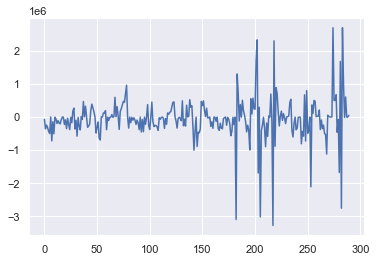

In [311]:
plt.plot(dxs);

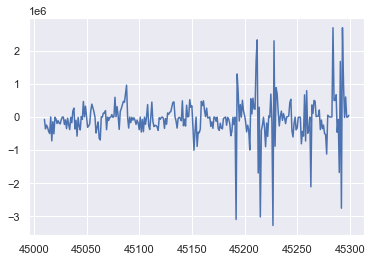

In [312]:
plt.plot(amounts_x)

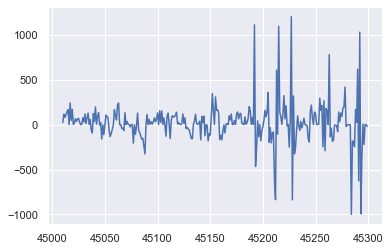

In [313]:
plt.plot(amounts_y)

<Figure size 600x500 with 0 Axes>

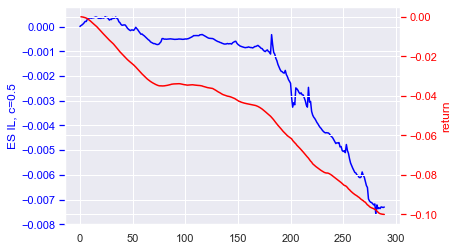

In [382]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(il_x['il'], color="blue")              
ax1.set_ylabel('ES IL, c=0.5', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

NameError: name 'il_x1' is not defined

<Figure size 600x500 with 0 Axes>

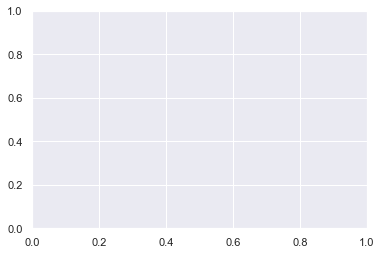

In [116]:
plt.figure(figsize = (6,5), dpi =100)
#plt.title(' IL vs return, c=0.5')
fig, ax1 = plt.subplots()
#fig.title('IL vs return, c=0.5')
ax1 = plt.subplot()
ax1.plot(il_x1['il'], color="blue")              
ax1.set_ylabel('ES IL, c=0', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x1['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

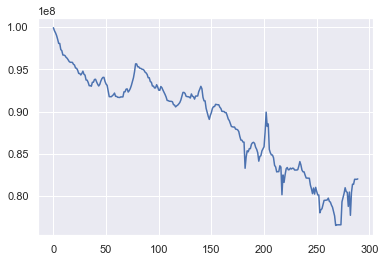

In [241]:
il_x1['x_coords'].plot();

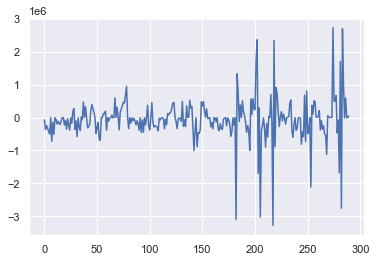

In [242]:
plt.plot(il_x1['dx'])

In [85]:
875800*0.45

394110.0

In [134]:
#IL in ES:
x_price = 1
y_price = test_set['ma'].iloc[0]
x_centre = 10000000
y_centre = x_centre/y_price
x_coord = x_centre
y_coord = y_centre
c = 1
x_ins = []
x_outs = []
y_ins = []
y_outs = []
amount_xs = test_set['amount0']  #[-2, 2, 1, -2, 2, -4, 2, 1, -2]
y_prices = test_set['ma']
x_coords = []
y_coords = []
y_ps = []
p_effs = []

y_x = 0
y_xs = []
x_xs = []
regions = []

for (amount_x, y_price) in zip(amount_xs, y_prices): 
    if amount_x < 0:
        y_in = getYEulerSwap(c, x_centre, x_coord, amount_x, x_price, y_price) - y_coord
        y_coord += abs(y_in)
        x_coord -=abs(amount_x)
        y_x += abs(y_in)
        x_x = x_coord
        p_eff = amount_x/y_in
        
        p_effs.append(abs(p_eff))
        y_ps.append(y_price)
        y_xs.append(y_x)
        x_xs.append(x_x)
        y_ins.append(y_in)
        x_coords.append(x_coord)
        y_coords.append(y_coord)
        regions.append('fx')
        
    else:
        amount_y = amount_x/y_price
        if abs(amount_y) < y_x: 
            x_in = x_coord - getXEulerSwap(c, x_centre, y_coord, abs(amount_y), y_price, x_price)
            y_coord -= abs(amount_y)
            x_coord+=x_in
            x_x = x_coord
            y_x = y_coord
            regions.append('xy')
        else: 
            x_x += (abs(amount_y) - y_x) * y_price
            x_coord += abs(amount_y) * y_price
            y_coord -= abs(amount_y)
            y_x = 0
            x_in = amount_y * y_price
            regions.append('gy')
            
        p_eff = x_in/amount_y
        p_effs.append(abs(p_eff))
        x_ins.append(x_in)
        x_xs.append(x_x)
        y_xs.append(y_x)
        y_ps.append(y_price)
        y_outs.append(amount_y)
        x_coords.append(x_coord)
        y_coords.append(y_coord) 


In [121]:
getXEulerSwap(1, 1000, 500, -2, 2, 1) - 1000

4.0

In [135]:
il_x1 = pd.DataFrame()
il_x1['x_coords'] = x_xs
il_x1['p_eff'] = p_effs
il_x1['price'] = y_ps
il_x1['y_total'] = y_xs
il_x1['regions'] = regions
il_x1['value_x'] = il_x1['x_coords'] + il_x1['y_total']*il_x1['price']
#il_x = il_x.iloc[1:]
il_x1['il'] = (il_x1['value_x'] - x_centre)/x_centre
il_x1['return'] = (il_x1['price'].shift(1) - il_x1['price'].iloc[0]) / il_x1['price'].iloc[0]

In [136]:
il_x1['dif'] = il_x1['y_total'] - il_x['y_total']

In [137]:
il_x1_s = il_x1[il_x1['regions'] == 'xy']
dif = il_x1_s['p_eff'] - il_x1_s['price']

<AxesSubplot:>

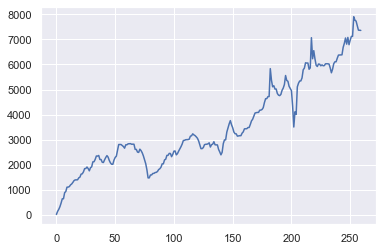

In [113]:
il_x['y_total'].plot()

In [96]:
il_x.head(10)

,x_coords,price,y_total,value_x,il,return
0,9.992726e+07,3014.732181,24.380347,1.000008e+08,0.000008,NaN
1,9.956825e+07,3014.516720,144.743701,1.000046e+08,0.000046,0.000000
2,9.932426e+07,3014.213492,226.584672,1.000072e+08,0.000072,-0.000071
3,9.900561e+07,3013.793361,333.586986,1.000110e+08,0.000110,-0.000172
4,9.857064e+07,3013.300345,479.566424,1.000157e+08,0.000157,-0.000311
5,9.807037e+07,3012.617963,647.666724,1.000215e+08,0.000215,-0.000475
6,9.807094e+07,3011.952648,647.473962,1.000211e+08,0.000211,-0.000701
7,9.734885e+07,3010.754509,890.351219,1.000295e+08,0.000295,-0.000922
8,9.720634e+07,3009.623735,938.350615,1.000304e+08,0.000304,-0.001319
9,9.669786e+07,3008.169583,1109.900622,1.000366e+08,0.000366,-0.001694


In [76]:
p_diff = il_x1['p_eff'] +il_x1['price']

In [84]:
il_x1_s = il_x1[il_x1['p_eff'] > 6000]

In [60]:
dif = il_x1['x_coords'] - il_x['x_coords']

In [50]:
il_x = il_x.head(260)

In [1005]:
1000 - getXEulerSwap(1, 1000, 500, 1, 2, 1)

2.0

In [ ]:
[-2, 2, 1, -2, 2, -4, 2, 1, -2]

In [ ]:
x_coord_right = [999, 1001, 1002, 1000, 1002, 998, 1000, 1001, 999]
y_coord_right = [500.5, 499.5, 499, 500, 499, 501, 500, 499.5, 500.5 ]

In [11]:
y_ins

[0, 1.0, 2.125, 2.0, 1.0]

In [91]:
x_coords

[998, 1000.0, 1001.0, 999.0, 1001.0, 997.0, 999.0, 1000.0, 998.0]

In [92]:
y_coords

[501.0, 500.0, 499.5, 500.5, 499.5, 501.5, 500.5, 500.0, 501.0]

# IL and fee models

In [3]:
df = pd.read_csv('/Users/ayanaaspembitova/work/Euler/SwapData/data/ETH-USDC500days.csv')
df['price'] = abs(df['amountUSD']/df['amount1'])
df.head()

,Unnamed: 0,id,timestamp,origin,amount0,amount1,amountUSD,tick,sqrtPriceX96,logIndex,transaction.blockNumber,transaction.gasUsed,transaction.gasPrice,price
0,0,0xc8694acfe92e60f0544cc284f3bce58838c61fdedb60...,1625692566,0x422162745b12b8c58d19e348d7c8c134bbedf886,-131939.211505,55.994080,132148.011927,198643,1629840339710206611127696549354436,48,12782658,300000,35530570548,2360.035431
1,1,0x83220039885b8aa0354677f567219b85d21feb739d5b...,1625692588,0x422162745b12b8c58d19e348d7c8c134bbedf886,-133706.922423,56.762064,133918.661798,198646,1630097389472588771364993582965591,245,12782662,300000,34247960810,2359.298652
2,2,0x7d9bcf10b6fafe79f54db4b5bcc9cd60c814630890f1...,1625692639,0x422162745b12b8c58d19e348d7c8c134bbedf886,-418450.004264,177.911121,419182.984007,198664,1631598611109045408663688169544926,69,12782663,300000,471649776372,2356.137057
3,3,0xe7e104cc2686484ba0a28a9e91b4cfe5029ea7a601c8...,1625692639,0xd248711655893f8bf0ccf44eeee4702cda9e7ba9,-363763.472613,154.517706,364389.069762,198654,1630797130401416290471491555444043,61,12782663,1200000,529776695835,2358.235048
4,4,0x31ccccf7f01bcd14895466c7059412d6793ac961b43b...,1625692854,0x4c5c2dd90634ec51d2a912314ccf8ab7046291c9,-622222.100000,264.870426,623385.166324,198679,1632785130698026974471086484650310,13,12782682,413230,0,2353.547641


In [200]:
(100/98)*0.7 + 0.3

1.0142857142857142

In [4]:
df['ma'] = df['price'].rolling(window=50).mean()

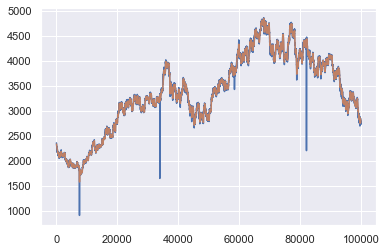

In [122]:
plt.plot(df['price']);
plt.plot(df['ma'], alpha = 0.8);


In [5]:
test_set = df.iloc[45010:45300]

In [6]:
amounts_x = test_set['amount0']
amounts_y = test_set['amount1']
y_prices = test_set['ma']
y_price0 = test_set['ma'].iloc[0]
y_ps = []
y_total = 0
y_totals = []
x0 = 100000000
x_coord = x0
x_coords = []
for amount_x, amount_y, y_price in zip(amounts_x, amounts_y, y_prices):
    
    if amount_x < 0:
        y_in = abs(amount_y)
        y_total += y_in
        x_coord = x_coord - abs(amount_x) 
    else:
        if abs(amount_y) < y_total:
            y_total -= abs(amount_y)
            x_coord += amount_x
        else: 
            y_total = 0
            x_coord = x_coord + (abs(amount_y) - y_total) * 1/y_price
    
    x_coords.append(x_coord) 
    y_totals.append(y_total)
    y_ps.append(y_price)

In [174]:
amounts_x = test_set['amount0']
amounts_y = test_set['amount1']
y_prices = test_set['ma']
y_price0 = test_set['ma'].iloc[0]
y_ps = []
y_total = 0
y_totals = []
x0 = 100000000
x_coord = x0
x_coords = []
fees_es2 = []
for amount_x, amount_y, y_price in zip(amounts_x, amounts_y, y_prices):
    
    if amount_x < 0:
        y_in = abs(amount_y)
        y_total += y_in
        
        ret = (y_price-y_price0)/y_price0
        if ret <0:
            fee = amount_x *2*ret
        else:
            fee = 0
        x_coord = x_coord - abs(amount_x) + fee
    else:
        if abs(amount_y) < y_total:
            y_total -= abs(amount_y)
            x_coord += amount_x
        else: 
            y_total = 0
            x_coord = x_coord + (abs(amount_y) - y_total) * 1/y_price
            
        fee = 0
    fees_es2.append(fee)
    
    y_price0 = y_price
    x_coords.append(x_coord) 
    y_totals.append(y_total)
    y_ps.append(y_price)

In [179]:
amounts_x = test_set['amount0']
amounts_y = test_set['amount1']
y_prices = test_set['ma']
y_price0 = test_set['ma'].iloc[0]
y_ps = []
y_total = 0
y_totals = []
x0 = 100000000
x_coord = x0
x_coords = []
fees_es1 = []
for amount_x, amount_y, y_price in zip(amounts_x, amounts_y, y_prices):
    
    if amount_x < 0:
        y_in = abs(amount_y)
        y_total += y_in
        
        ret = (y_price-y_price0)/y_price0
        fee = amount_x *2*ret
        
    else:
        if abs(amount_y) < y_total:
            y_total -= abs(amount_y)
            x_coord += amount_x
        else: 
            y_total = 0
            x_coord = x_coord + (abs(amount_y) - y_total) * 1/y_price
        fee = 0
            
    fees_es1.append(fee)
    y_price0 = y_price
    x_coords.append(x_coord) 
    y_totals.append(y_total)
    y_ps.append(y_price)

In [7]:
il_x = pd.DataFrame()
il_x['x_coords'] = x_coords
il_x['price'] = y_ps
il_x['y_total'] = y_totals
il_x['value_x'] = il_x['x_coords'] + il_x['y_total']*il_x['price']
#il_x = il_x.iloc[1:]
il_x['il'] = (il_x['value_x'] - x0)/x0
il_x['return'] = (il_x['price'].shift(1) - il_x['price'].iloc[0]) / il_x['price'].iloc[0]

In [8]:
il_x = il_x.iloc[1:]

<Figure size 600x500 with 0 Axes>

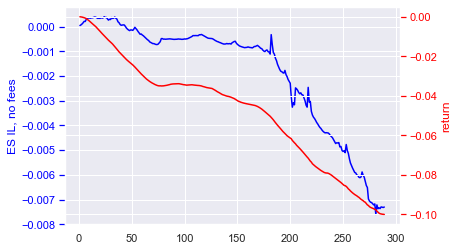

In [9]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(il_x['il'], color="blue")              
ax1.set_ylabel('ES IL, no fees', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

<Figure size 600x500 with 0 Axes>

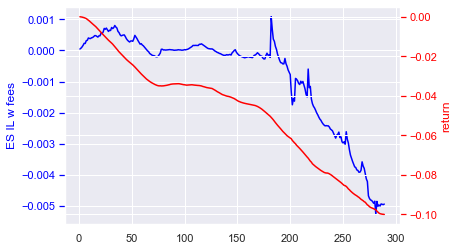

In [152]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(il_x['il'], color="blue")              
ax1.set_ylabel('ES IL w fees', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

<Figure size 600x500 with 0 Axes>

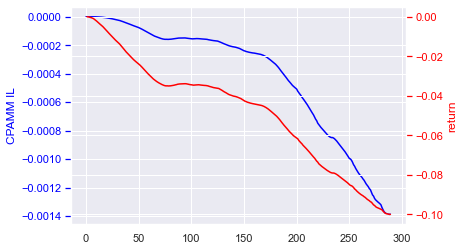

In [922]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(ils, color="blue")              
ax1.set_ylabel('CPAMM IL', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
#plt.savefig('/Users/ayanaaspembitova/work/Euler/EulerSwap/cpamm_il.png')
plt.show();

In [158]:
#Fees paid by traders in CPAMM: 
fees = []
amounts = test_set['amountUSD']
for a in amounts:
    fee = a*0.003
    fees.append(fee)

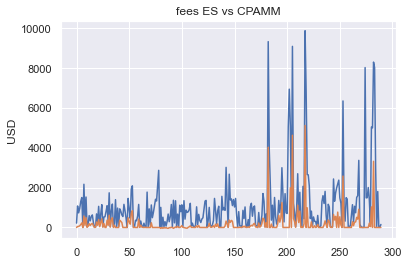

In [191]:
plt.plot(fees);
plt.plot(fees_es1);
plt.ylabel('USD')
plt.title('fees ES vs CPAMM', size=12);

In [190]:
print(sum(fees_es1))
print(sum(fees))

54108.54523799728
308444.00912225054


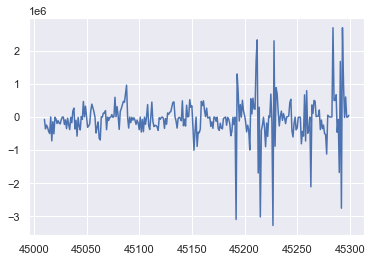

In [165]:
plt.plot(amounts_x);

In [864]:
test_set['date'] = pd.to_datetime(test_set['timestamp'],unit='s')

In [921]:
# IL in UniV2:
il_df = pd.DataFrame()
prices_y = test_set['ma']
#prices_y = #btc['btc']
price_y = prices_y[45010]
price_x = 1 #prices_y[1]
xt = 100000
yt = xt*(price_x/price_y)
k = xt*yt
val = xt*price_x + yt *price_y

ils = []

for price_y in prices_y:
    val = xt*price_x + yt *price_y
    rt = price_x/price_y
    x_t = np.sqrt(k/rt)
    y_t = np.sqrt(k*rt)
        
    il = ((x_t*price_x + y_t*price_y) - val)/val
    ils.append(il)

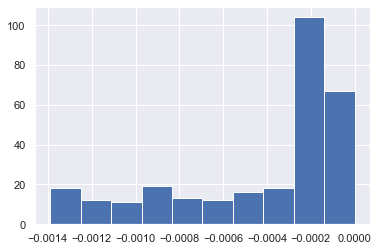

In [691]:
plt.hist(ils);

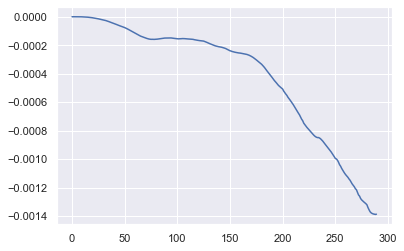

In [692]:
plt.plot(ils);

In [915]:
#IL for UniV3 

prices_y = test_set['ma']
#prices_y = btc['btc']
#prices = prices_x/prices_y
pa = 3100
pb = 3300
xt = 500
price_x = 1
price_y = prices_y[45010]
yt = xt*(price_x/price_y)
L = np.sqrt(xt*yt)
ils_u3 = []

for price_y in prices_y: 
    val = xt*price_x + yt *price_y
    x_t = (L/np.sqrt(pa)) - (L/np.sqrt(pb))
    y_t = L *(np.sqrt(pb) - np.sqrt(pa))
    if price_x<=pa:
        il = ((x_t *price_x) - val)/val
    elif price_x>=pb:
        il = ((y_t *price_y) - val)/val
    else: 
        il = ((x_t *price_x + y_t*price_y) - val)/val
    ils_u3.append(il) 
        

Impermanent Loss for $x$ LPs, all swaps are on $f(x)$ side: 

$IL = \frac{x_{t0} - x_t}{x_{t0}}$

$x_t = x_{t0} - \Delta x + \Delta y \frac{p_y}{p_x}$

In [693]:
#IL in ES:
x_price = 1
y_price = test_set['ma'].iloc[0]
x_centre = 10000000
y_centre = x_centre/y_price
x_coord = x_centre
y_coord = y_centre
c_x = c_y = 1
x_ins = [0]
x_outs = []
y_ins = [0]
y_outs = []
amount_xs = test_set['amount0']
y_prices = test_set['ma']
x_price = 1
x_coords_x = [x_coord]
y_coords_x = [y_coord]
y_price_x = [y_price]
y_price_xy = [y_price]
eff_prices = []
oracle_prices = []

for y_price, amount_x in zip(y_prices, amount_xs): 
    if amount_x <0:
        y_coord = x_centre/y_price
        x_out_X_side, y_in_X_side, x_c0, y_c0 = swapXOutXSide(amount_x, c_x, x_centre, x_centre, y_coord, x_price, y_price)
        x_outs.append(x_out_X_side)
        y_ins.append(y_in_X_side)
        x_c = x_coords_x[-1] - amount_x
        x_coords_x.append(x_c)
        y_c = y_coords[-1] + y_in_X_side
        y_coords.append(y_c)
        y_price_x.append(y_price)
        eff_price = x_out_X_side/y_in_X_side
        
    else: 
        x_coord = x_coord + amount_x
        y_coord = x_centre/y_price
        x_in_X_side, y_out_X_side, x_c, y_c = swapXInXSide(amount_x, c_x, x_centre, x_centre, y_coord, x_price, y_price)
        x_ins.append(x_in_X_side)
        y_outs.append(y_out_X_side)
        x_c = x_coords[-1] + x_in_X_side
        x_coords.append(x_c)
        y_c = y_coords[-1] - y_out_X_side
        y_coords_x.append(y_c)
        y_price_xy.append(y_price)
        eff_price = x_in_X_side/y_out_X_side
    eff_prices.append(abs(eff_price))
    oracle_prices.append(y_price)
        


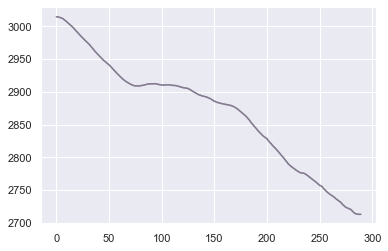

In [694]:
plt.plot(eff_prices);
plt.plot(oracle_prices, alpha = 0.4);

In [695]:
il_x = pd.DataFrame()
il_x['y_in'] = y_ins
il_x['x_coords'] = x_coords_x
il_x['price'] = y_price_x
il_x['y_total'] = il_x['y_in'].cumsum()
il_x['value_x'] = il_x['x_coords'] + il_x['y_total']*il_x['price']
il_x = il_x.iloc[1:]
il_x['il'] = (il_x['value_x'] - x_centre)/x_centre

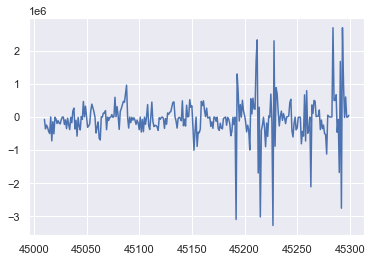

In [696]:
test_set['amount0'].plot();

In [697]:
il_x['return'] = (il_x['price'].shift(1) - il_x['price'].iloc[0]) / il_x['price'].iloc[0]

<Figure size 600x500 with 0 Axes>

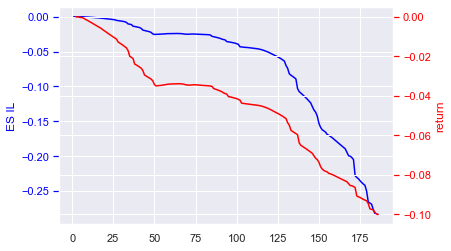

In [698]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(il_x['il'], color="blue")              
ax1.set_ylabel('ES IL', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

In [671]:
print(il_x['return'].corr(il_x['il']))
#print(il_x['return'].corr(ils))

-0.9812010961926736


<Figure size 600x500 with 0 Axes>

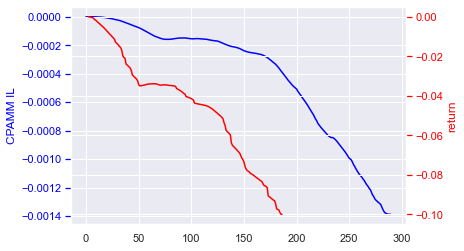

In [699]:
plt.figure(figsize = (6,5), dpi =100)
fig, ax1 = plt.subplots()

ax1 = plt.subplot()
ax1.plot(ils, color="blue")              
ax1.set_ylabel('CPAMM IL', color="blue")       
ax1.tick_params(axis='y', colors="blue")       

ax2 = ax1.twinx()
ax2.plot(il_x['return'], color="red")      
ax2.set_ylabel('return', color="red")       
ax2.tick_params(axis='y', colors="red")
plt.show();

In [425]:
pp = pd.DataFrame()
pp['out'] = x_outs
pp['y_in'] = y_ins
pp['price'] = pp['out']/pp['y_in']

In [421]:
pp = pd.DataFrame()
pp['x_in'] = x_ins
pp['y_out'] = y_outs
pp['price'] = pp['x_in']/pp['y_out']

In [252]:
p = pp['out']/pp['y_in']

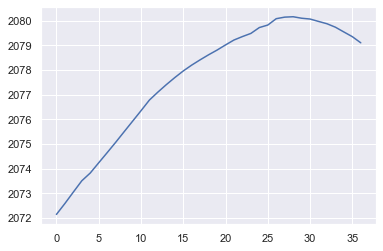

In [413]:
pp['price'].plot();

In [363]:
test_set_out = test_set[test_set['amount0']<0]

In [393]:
swapXOutXSide(139694.746797, 1, 10000000, 10000000, 10000000/2360, 1, 2073)

(139694.746797, -519.2508191597954, 9860305.253203, 3718.037316433425)

In [364]:
test_set_out

,Unnamed: 0,id,timestamp,origin,amount0,amount1,amountUSD,tick,sqrtPriceX96,logIndex,transaction.blockNumber,transaction.gasUsed,transaction.gasPrice,price,ma,date
10012,12,0x84b128dd452d551149f158cb1fbbb07ac195cad96f97...,1627018952,0xdc9dcb1f7979ff6cbf3d11c46e210125e7f86bf0,-19257.487499,9.259300,19286.686206,199890,1734688504017566692943668022044144,18,12880808,2966445,0,2082.952939,2072.150506,2021-07-23 05:42:32
10013,13,0x281aca0cff2210ed1edc926e6bd1512e7bccc6193a2c...,1627018972,0xcf16bc9eaf3081822cdf51ebf29514e0d61cbdf6,-83181.644536,40.000000,83311.001201,199892,1734863517982413600230165566551513,3,12880809,1200000,1,2082.775030,2072.591505,2021-07-23 05:42:52
10014,14,0xd9c38bff243bf5d023b35e0540479d14122148240319...,1627018979,0x68efce9676aabf7aee3b804c32e5973303159207,-35848.901280,17.241341,35903.617980,199893,1734938934656285330520100053376765,25,12880810,1200000,29097236028,2082.414517,2073.055327,2021-07-23 05:42:59
10015,15,0x2f3079261bbbb2b61f3e4b101cf4055cc5273692d6a2...,1627018997,0x4e398cb73b2e81485d4d9fb5ae1a767b839e368d,-139694.746797,67.199758,139916.789000,199896,1735232878286364281595155267289719,14,12880814,1200000,30000000001,2082.102567,2073.513090,2021-07-23 05:43:17
10016,16,0xfe9ebd6185c27df573ada53b6d30bc89a380baf7dc73...,1627018997,0xf6b22254f5804e74c7aea9b7000a596f587d9dd0,-64842.422046,31.200000,64942.535916,199897,1735369352605710385125266756215182,41,12880814,1478101,30000000000,2081.491536,2073.828716,2021-07-23 05:43:17
10017,17,0x306f8a92e058cbdd7a7724f4fe4f99cf995ee0ab8d19...,1627019004,0x5a243879d1a43f48042c33bbc8051c69756f67d4,-195663.125696,94.176292,195980.796755,199902,1735781296368811006393326208229104,3,12880816,1200000,0,2080.999280,2074.242812,2021-07-23 05:43:24
10018,18,0xdf00eef873da423f241a258ffd79c9a4dcb40602d07c...,1627019023,0x17f32caca965ffc80996dfedb5515bb958140edf,-50000.646956,24.073412,50077.394818,199903,1735886597732467470260164080521212,176,12880818,1200000,20000000001,2080.195129,2074.653488,2021-07-23 05:43:43
10019,19,0xbad96e290a86a940cca7d5d9ae3edd0095d812f0b0c9...,1627019036,0x2b43667071de0df373436998bef3816507eab5e9,-469.202698,0.225936,469.908754,199904,1735961115192999655841972166846599,71,12880819,266828,20700000000,2079.828963,2075.069809,2021-07-23 05:43:56
10020,20,0xfeb0fce128d4f84958e88355912a8fce86d2bed4ea32...,1627019036,0x68efce9676aabf7aee3b804c32e5973303159207,-34910.541293,16.809831,34963.806275,199904,1735960126907878644885463207800060,67,12880819,1200000,20700000001,2079.961770,2075.499175,2021-07-23 05:43:56
10021,21,0x4970b56a5786c2642559704d172c880598475b995d7c...,1627019045,0x4e398cb73b2e81485d4d9fb5ae1a767b839e368d,-171679.146543,82.686323,171955.378491,199908,1736322799798207396913885623919958,121,12880820,1200000,33750300001,2079.610893,2075.925611,2021-07-23 05:44:05


In [ ]:
#IL in UniV3:

# Simulations

Simulating 5000 steps ahead for 1000 price trajectories and getting output metrics

In [ ]:
N_sim = 1000
T = 5000
mQ = eps.dropna().cov() # unconditional covariance matrix of standartized residuals
dof = 5
dim = returns.shape[1]
S_mult_sim = np.zeros([N_sim, dim, T])
So = df.iloc[-1,:]
returns_df = pd.DataFrame()
prices_df = pd.DataFrame()

for n in range(1, N_sim):
    ret, S = simulate_Student_t_GARCH_mult(So, dof, T, mQ, returns, df_params)
    S_mult_sim[n] = S.T

    returns_df['eth_'+'{}'.format(n)], returns_df['aave_'+'{}'.format(n)] = ret[:,0], ret[:,1]
    prices_df['eth_'+'{}'.format(n)], prices_df['aave_'+'{}'.format(n)] = S[:,0], S[:,1]

In [ ]:
#Check the simulation time
print(datetime.now()-start)

In [ ]:
# This is toy dataset, but price_xs, price_ys, amounts can be changed to the price and trade simulation outputs: 

x_reserve = 500000
y_reserve = 2000
price_ys = [2, 2.1, 2, 1.9, 2.2]
amounts_xs = [10, -2, 5, 7, -8]
amounts_ys = [-2, 4, 5, 11, -7]
x_virtual = (y_reserve * y_price)/x_price
y_virtual = (x_reserve * x_price)/y_price
c_x = c_y = 1
fee = 0.003
x_price = 1
prices_eff = []
curves = []
y=x=1
curve = 'gy'
x_excess = y_excess = 0
x_coord = x_reserve + x_excess
y_coord = y_reserve + y_excess
y_exs = []

for y_price, amount_x, amount_y in zip(price_ys, amounts_xs, amounts_ys): 
    trades = ["trades_sim_x", "trades_sim_y"]
    token_chosen = random.choice(trades)
    
    if token_chosen == "trades_sim_x": #X token
        amount = amount_x
        if amount>0: #Swap In x
            if curve == 'fx':
                x_in, y_out, fee_value, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord = swapXInXSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_in/y_out
            else: 
                x_in, y_out, fee_value, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord = swapXInYSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_in/y_out
                
                
        else: #Swap out x
            if curve == 'fx': 
                x_out, y_in, fee_value, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord = swapXOutXSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_out/y_in
            else: 
                x_out, y_in, fee_value, active_region, x_reserve, y_reserve, x_excess, y_excess, x_coord, y_coord = swapXOutYSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_out/y_in
                
            if active_region == 0:
                curve =='gy'
            else:
                curve =='fx'
            
            
    else: # Y token
        amount = amount_y
        if amount>0: #Swap In y
            if curve == 'gy': 
                y_in, x_out, fee_value, active_region, y_reserve, x_reserve, y_excess, x_excess, y_coord, x_coord = swapXInXSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_out/y_in
            else: 
                y_in, x_out, fee_value, active_region, y_reserve, x_reserve, y_excess, x_excess, y_coord, x_coord = swapXInYSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_out/y_in
                
        else: #Swap out y
            if curve =='gy':
                y_out, x_in, fee_value, active_region, y_reserve, x_reserve, y_excess, x_excess, y_coord, x_coord = swapXOutXSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_in/y_out
            else: 
                y_out, x_in, fee_value, active_region, y_reserve, x_reserve, y_excess, x_excess, y_coord, x_coord = swapXOutYSide(amount, x_excess, y_excess, fee, x_reserve, y_reserve, x_price, y_price, x_coord, y_coord)
                price_eff_y = x_in/y_out
                
            if active_region == 0:
                curve =='fx'
            else:
                curve =='gy'
                
    prices_eff.append(price_eff_y)

In [1]:
ye = 1.4
c = 1
p = 0.556
xc = 10
x = 8

fh = ye + p*(c*(2*xc - x) + (1-c)*(xc**2/x)-xc)
fh

2.512

In [25]:
c = 0.7
p = 0.5
xc = 100000
x = 1#500000
q = 0.836
a = 1.2

dx = p*q*(c+(1-c)*((x**2)/(a*x)))
cx3 = (a-x*dx)/a-x
#cx4 = ((a-1)*(p*(c+(1-c)*xc**2 * (1/a)) - q*a))/(q*(2*a -1 - a**2))
cx3

-0.33091666666666664

In [22]:
p*(c+(1-c)*xc**2 * (1/a))

15000000.350000001

In [32]:
(2000000*0.2-300000)/3.67

27247.956403269756

In [34]:
551000-300000/3.67

469256.1307901907